# PCA for dimensionality Reduction

There are multiple analyses I do at any given time that have multiple classes. And the only way to get to the 
root of the data is to visualize the different classes in light if only the interesting features.
In the below experiment I have performed PCA on a multiclass dataset. Using 9 raw elements, you can predict the type of glass. This was an interesting dataset as it was originally created for forensic testing. I got this dataset from UCI website: https://archive.ics.uci.edu/ml/datasets.html
With 54 features this dataset is a good candidate for dimensionality reduction.

In [131]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score,KFold
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Load data
X = pd.read_csv('covtype.csv')

In [304]:
#Dataset Continuous columns
Cols1to10H = ['Elev', 'Aspect','Slope','Hhyd','Vhyd','Hroad','Shade9','Shade12','Shade15','Hfire']
Cols1to10=X.iloc[:,0:10]
Cols1to10.columns=Cols1to10H

#Dataset Binary columns - Wilderness Area
binaryhead=[]
for i in range(1,5):
    binaryhead.append("WArea"+str(10+i))

Warea=X.iloc[:,10:14]
Warea.columns=binaryhead

#Dataset Binary columns - Soil Type
binaryhead=[]
for i in range(1,41):
    binaryhead.append("WArea"+str(14+i))
binaryhead

Stype=X.iloc[:,14:54]
Stype.columns=binaryhead

#Dataset Label
Coverlabel=pd.DataFrame(X.iloc[:,54])
Coverlabel.columns=['label']

#Complete dataset
Coverdata1=pd.concat([Cols1to10,Warea,Stype,Coverlabel],axis=1)

Name / Data Type / Measurement / Description 

Elevation / quantitative /meters / Elevation in meters 
Aspect / quantitative / azimuth / Aspect in degrees azimuth 
Slope / quantitative / degrees / Slope in degrees 
Horizontal_Distance_To_Hydrology / quantitative / meters / Horz Dist to nearest surface water features 
Vertical_Distance_To_Hydrology / quantitative / meters / Vert Dist to nearest surface water features 
Horizontal_Distance_To_Roadways / quantitative / meters / Horz Dist to nearest roadway 
Hillshade_9am / quantitative / 0 to 255 index / Hillshade index at 9am, summer solstice 
Hillshade_Noon / quantitative / 0 to 255 index / Hillshade index at noon, summer soltice 
Hillshade_3pm / quantitative / 0 to 255 index / Hillshade index at 3pm, summer solstice 
Horizontal_Distance_To_Fire_Points / quantitative / meters / Horz Dist to nearest wildfire ignition points 
Wilderness_Area (4 binary columns) / qualitative / 0 (absence) or 1 (presence) / Wilderness area designation 
Soil_Type (40 binary columns) / qualitative / 0 (absence) or 1 (presence) / Soil Type designation 
Cover_Type (7 types) / integer / 1 to 7 / Forest Cover Type designation

In [305]:
std_scale = preprocessing.StandardScaler().fit(Cols1to10)
std1to10 = pd.DataFrame(std_scale.transform(Cols1to10))
std1to10.columns=Cols1to10H
#Complete dataset
Coverdata=pd.concat([std1to10,Warea,Stype,Coverlabel],axis=1)
Coverdata[:3]

,Elev,Aspect,Slope,Hhyd,Vhyd,Hroad,Shade9,Shade12,Shade15,Hfire,...,WArea46,WArea47,WArea48,WArea49,WArea50,WArea51,WArea52,WArea53,WArea54,label
0,-1.319238,-0.890481,-1.616367,-0.270188,-0.899198,-1.257108,0.293388,0.590899,0.221342,3.205535,...,0,0,0,0,0,0,0,0,0,5
1,-0.554909,-0.148838,-0.681566,-0.006720,0.318741,0.532210,0.816364,0.742654,-0.196691,3.126996,...,0,0,0,0,0,0,0,0,0,2
2,-0.622770,-0.005870,0.520320,-0.129044,1.227907,0.474490,0.965785,0.742654,-0.536342,3.194963,...,0,0,0,0,0,0,0,0,0,2


Finally! The complete dataset with all the Standardized features (Mean=0 & sd=1). Now we can get to business.

At this point I want to explore the contribution of each of these features towards the target class. The below plots display the different class across each feature. I see that the first 2 features distinguish the classes well but all the rest are making meagre contributions (classes are overlapping).

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


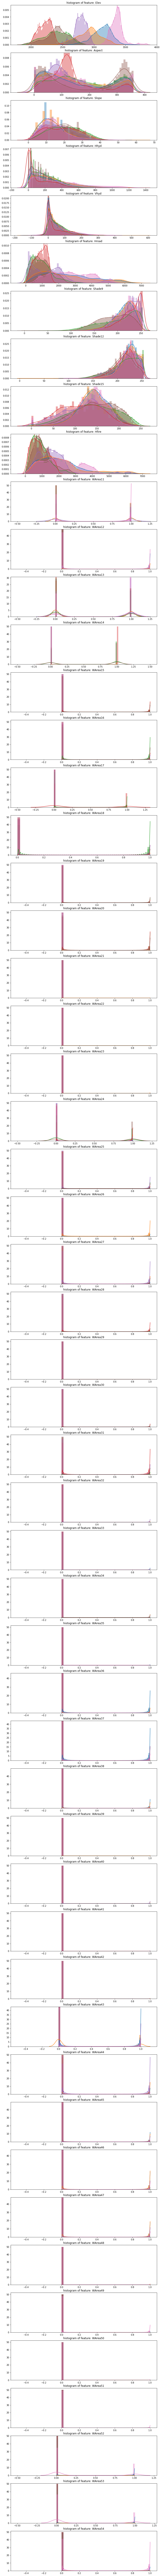

In [344]:
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
plt.figure(figsize=(12,54*4))
gs = gridspec.GridSpec(54, 1)
df=Coverdata1
v_features = df.iloc[:,0:54].columns

for i, cn in enumerate(df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.label == 1], bins=50)
    sns.distplot(df[cn][df.label == 2], bins=50)
    sns.distplot(df[cn][df.label == 3], bins=50)
    sns.distplot(df[cn][df.label == 4], bins=50)
    sns.distplot(df[cn][df.label == 5], bins=50)
    sns.distplot(df[cn][df.label == 6], bins=50)
    sns.distplot(df[cn][df.label == 7], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

In [331]:
from sklearn.model_selection import train_test_split

X_train = Coverdata.drop(['label'], axis='columns', inplace=False)
y_train = Coverdata['label']

X_train1 = Coverdata1.drop(['label'], axis='columns', inplace=False)
y_train1 = Coverdata1['label']

Now I will perform the Principal Component Analysis to determine good explanatory dimensions.

In [296]:
#perform PCA on feature set.
pca = PCA(n_components=30, whiten='True') #n_components=1, 2
pcax = pca.fit(X_train).transform(X_train)
pca.explained_variance_

array([2.5965587 , 2.25509907, 1.7526994 , 1.1615716 , 0.79300085,
       0.58607526, 0.4683731 , 0.38901776, 0.3287397 , 0.29410406,
       0.13029772, 0.08697543, 0.08437373, 0.07454832, 0.06110219,
       0.05004854, 0.04700802, 0.04244756, 0.03868452, 0.0328873 ,
       0.03027784, 0.02578141, 0.02460763, 0.02111036, 0.0196271 ,
       0.0177499 , 0.01488898, 0.01354431, 0.01065092, 0.00874543])

In [297]:
#Train a Random Forest with PCA
train_X, test_X, train_Y, test_Y = train_test_split(pcax, y_train, test_size=0.30, random_state=4)
rfpca = RandomForestClassifier(n_estimators = 30)
rfpca.fit(train_X,train_Y)
pred = rfpca.predict(test_X)
print(cross_val_score(rfpca, test_X, test_Y))

[0.90188452 0.89895183 0.90204482]


In [289]:
#Train a Random Forest without PCA
train_X, test_X, train_Y, test_Y = train_test_split(X_train, y_train, test_size=0.30, random_state=4)
rf = RandomForestClassifier(n_estimators = 30)
rf.fit(train_X,train_Y)
pred = rf.predict(test_X)
print(cross_val_score(rf, test_X, test_Y))

[0.91100594 0.90592245 0.90639953]


In [333]:
#Train a Random Forest without PCA & FeatureScaling
train_X, test_X, train_Y, test_Y = train_test_split(X_train1, y_train1, test_size=0.30, random_state=4)
rf = RandomForestClassifier(n_estimators = 50)
rf.fit(train_X,train_Y)
pred = rf.predict(test_X)
print(cross_val_score(rf, test_X, test_Y))

[0.9168402  0.91031135 0.91400737]


In the above 3 steps I trained 3 seperate Random Forest Models
    1. With PCA with Standardization
    2. Without PCA with Standardization
    3. Without PCA without Standardization
Model 1(with PCA) gives the same accuracy with less than half the number of features.
Model 3 with full set of features and non-scaled data provides relatively better accuracy at 91%


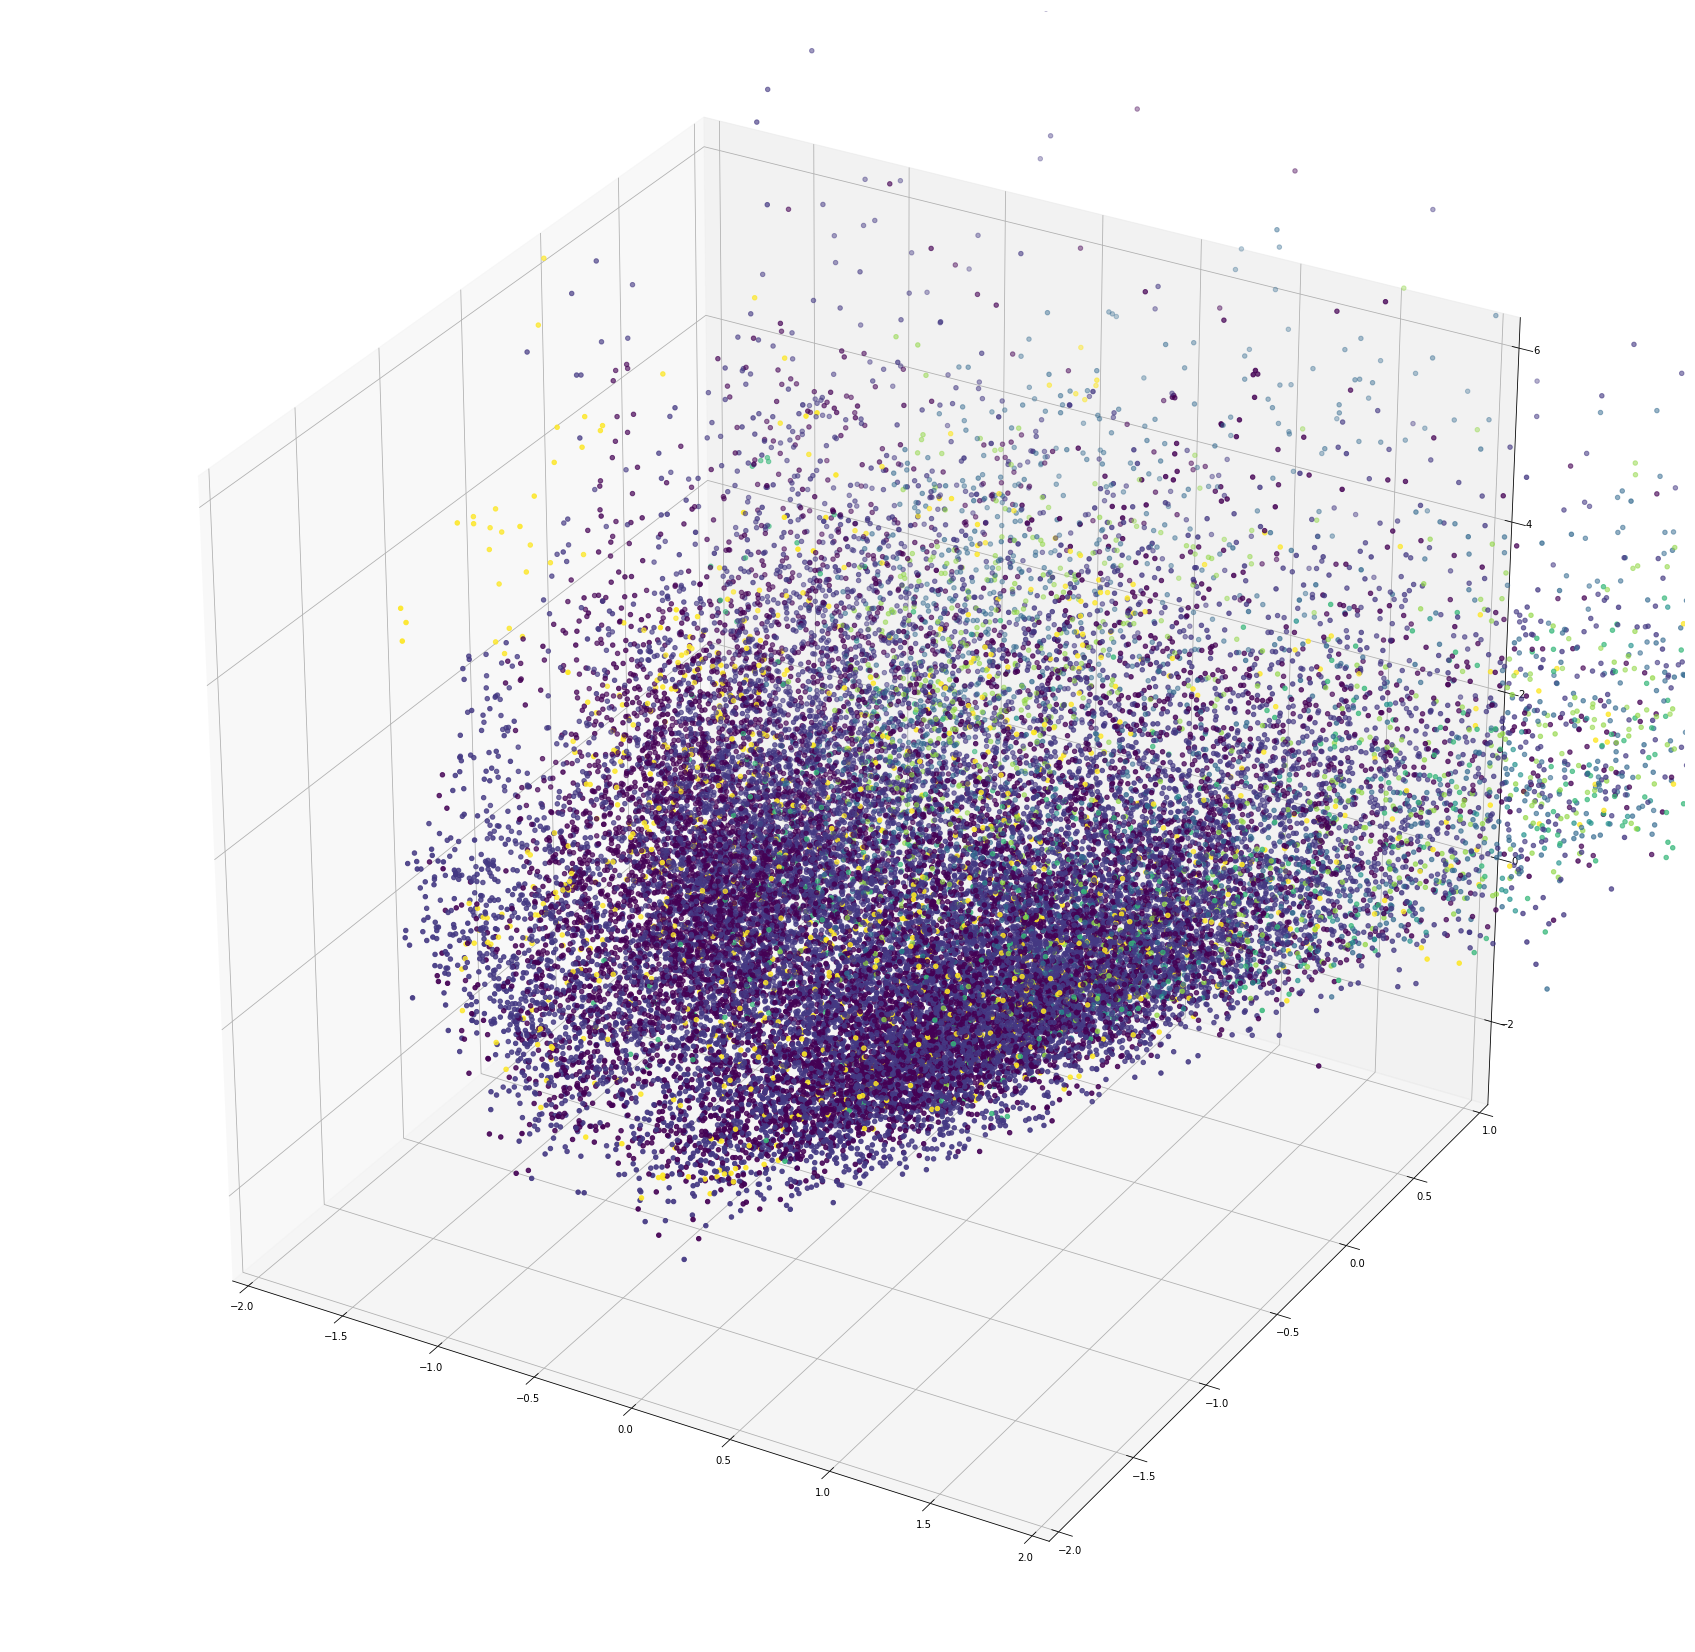

In [340]:
#PCA with 3D for Visualization
pca = PCA(n_components=3, whiten='True') #n_components=1, 2
pcax = pca.fit(X_train).transform(X_train)

#Samller subset for plotting
notplotX, plotX,notplotY,plotY = train_test_split(pcax,y_train,test_size=0.05, random_state=12300)

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111, projection='3d')
plt.xlim(-2, 2)
plt.ylim(-2, 1)
ax.set_zbound(lower=-2, upper=1)
ax.scatter(plotX[:,0], plotX[:,1], plotX[:,2],c=plotY[:])

Cant say this is a decent representation of the 7 types of forests but at least I tried. Seems like atleast 20 features are needed to classify this data.